<a href="https://colab.research.google.com/github/serkuz89/Process-Mining-23-24/blob/main/%D0%9A%D1%83%D0%B7%D1%8C%D0%BC%D0%B8%D0%BD%D0%BE%D0%B2_%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B9_%D0%9F%D0%B0%D0%B2%D0%BB%D0%BE%D0%B2%D0%B8%D1%87_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий

**Цель:** изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.

Для выполнения работы используются язык **Python** и библиотеки **PM4PY**, **Pandas**.

**Данные:**

## Начало работы. Чтение журнала событий

Библиотека **pm4py** работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Два соответствующих форматов в модуле есть два метода:
- **converter** из `pm4py.objects.conversion.log` (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий;
- **importer** из `pm4py.objects.log.importer.xes` (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.

Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки `pm4py.objects.conversion.log.converter` преобразуем его в журнал событий.


In [3]:
# Установка библиотеки для Process mining
!pip install pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26095 sha256=83cca6ccf2d09fe858b2ea3d98db4ccb7669b43745046080fc819e86f61bcedc
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=16968 sha256=19f12b4ce6d981d3348916e77d05c2a1685b78a9edd03c78b087c97eae5fb8f7
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist


In [4]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [5]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [6]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [7]:
type(log_csv)

pandas.core.frame.DataFrame

**Перед началом работы с любым набором данных, необходимо сначала его изучить:**
- названия колонок
- типы данных
- пропущенные значения
- и другое

In [38]:
log_csv.columns

Index(['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp',
       'caseend', 'casestart', 'relativetime', 'relativetime_s',
       'relativedays', 'caselength'],
      dtype='object')

In [9]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [10]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']})

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [11]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient')
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [12]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


<Axes: xlabel='relativetime_s', ylabel='patient'>

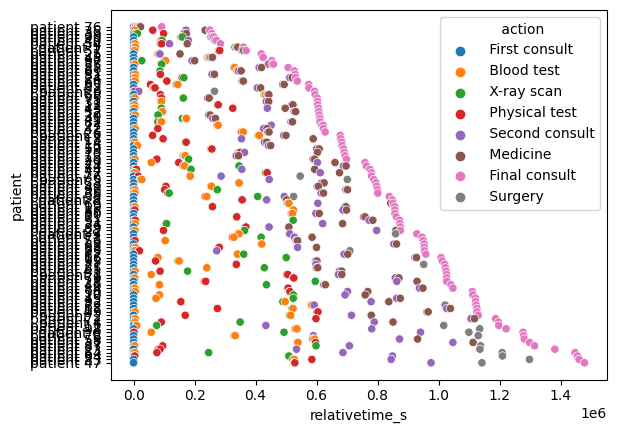

In [13]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])
import seaborn as sns
# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])



In [14]:
patient_events = pd.crosstab(log_csv['patient'], log_csv[' action'])
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [15]:
len(log_csv['patient'].unique())

100

In [16]:
patient_events.sum()

 action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ' First consult'),
  Text(1, 0, ' Blood test'),
  Text(2, 0, ' Physical test'),
  Text(3, 0, ' Second consult'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' Final consult'),
  Text(6, 0, ' X-ray scan'),
  Text(7, 0, ' Medicine')])

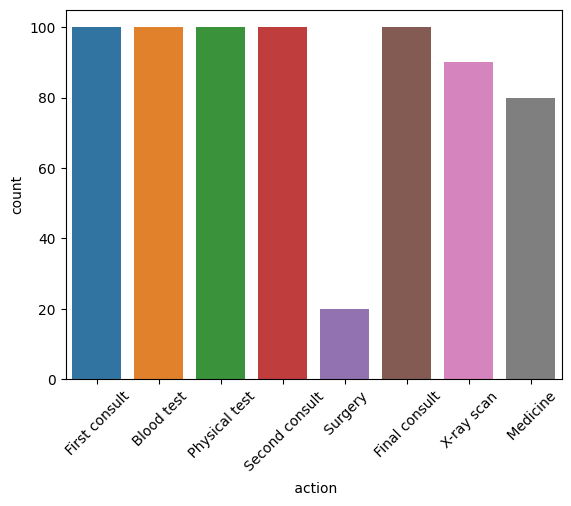

In [17]:
sns.countplot(x=log_csv[' action'])
import matplotlib.pyplot as plt
plt.xticks(rotation=45)

In [18]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

**Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:**

- **Идентификатор случая (case id):** хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
- **Деятельность (activity name):** хранит действия, выполняемые в рамках событий журнала.
- **Отметка времени (timestamp):** хранит дату и время регистрации событий журнала.
- **Ресурс (resource):** хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
- **Прочее (other data):** сюда попадает вся оставшаяся в журнале (не интересная нам) информация.

В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [19]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [20]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [21]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caselength': Timedelta('6 days 20:49:17')}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'caseend': Timestamp('2017-05-31 12:46:43'), 'casestart': Timestamp('20

In [22]:
log_csv.shape

(690, 10)

In [23]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [24]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [25]:
len(event_log[0])

6

**Важно!** помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [26]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [27]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [28]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [29]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

## Построение модели по журналу событий

### Alpha Miner

**Alpha miner** — один из самых известных алгоритмов интеллектуального анализа процессов и один из первых алгоритмов, способных обнаруживать параллелизм. Алгоритм использует прямую последовательность , причинно -следственные , параллельные и несвязанные отношения между переходами в журнале для обнаружения сети рабочего процесса.

http://mlwiki.org/index.php/Alpha_Algorithm

In [30]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)




Полученный процесс мы можем отобразить с помощью **Сетей Петри**.

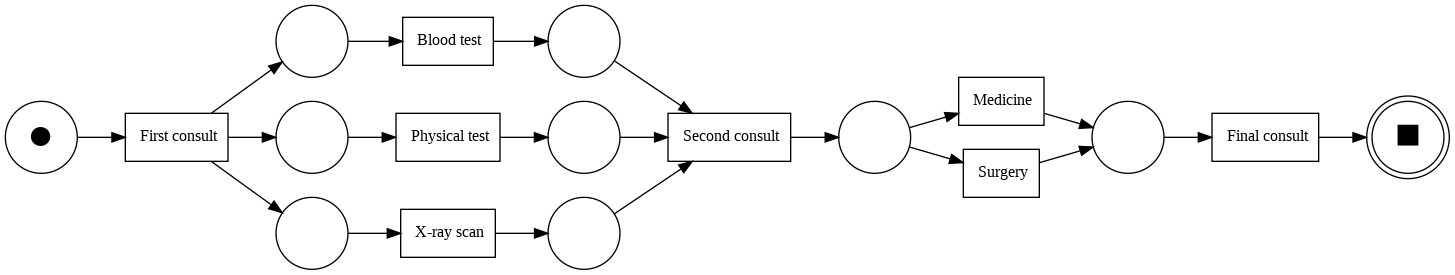

In [31]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

Чтобы получить представление о частоте переходов, можно установить параметр `pn_visualizer.Variants.FREQUENCY` при вызове `pn_visualizer.apply()`.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

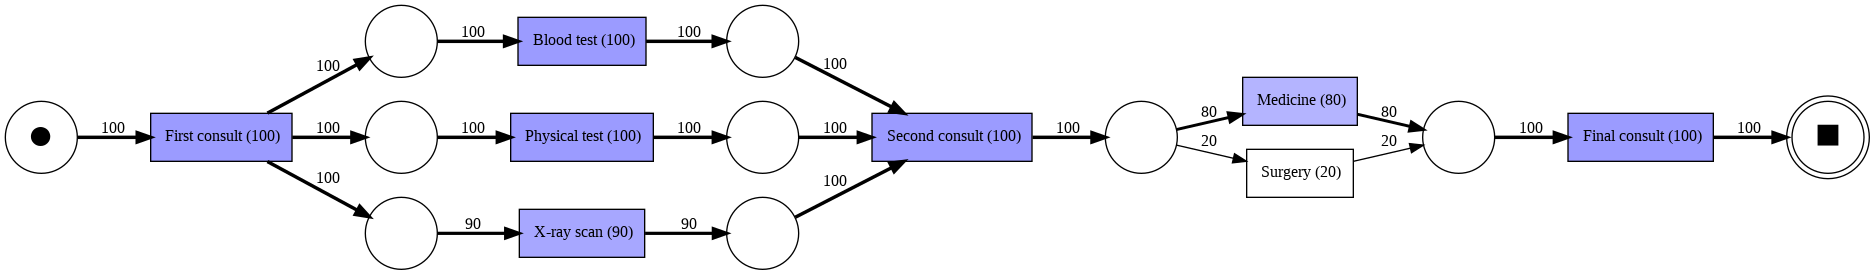

In [32]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [33]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция `get_transition_performance_with_token_replay` принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [34]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [35]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( X-ray scan, ' X-ray scan')", "( Blood test, ' Blood test')", "( Physical test, ' Physical test')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])

In [36]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


<Axes: xlabel='time:timestamp', ylabel='org:resource'>

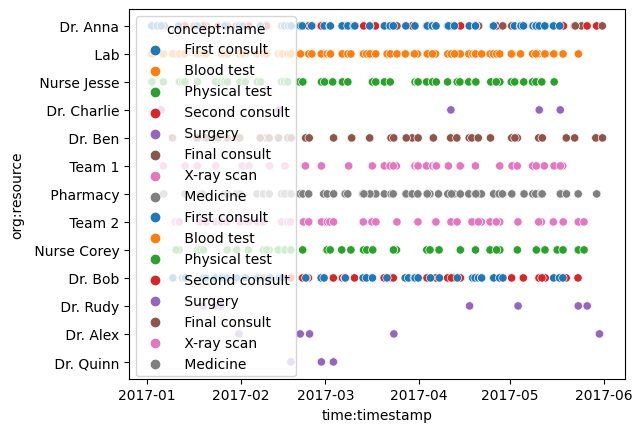

In [37]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])





## Задания. Изучение журнала событий

1. Каково минимальное и максимальное количество событий в одном случае?
2. Какие события являются общими для всех процессов?
3. Найдите наибоее часто встречающуюся последовательность событий.
4. Какой пациент на лечение тратил меньше всего времени, а какой больше?
6. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)
7. Pation 13 с каким врачом/врачами он/она консультировался?
8. Какое событие является наиболее ресурсоёмким в данном журнале событий?
9. Есть ли врачи или медсестры, которые перегружены работой?
10. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?
11. Какие события связаны с узкими местами и какие ресурсы задействованы?
12. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?
13. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.
Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

1. Каково минимальное и максимальное количество событий в одном случае?

In [39]:
print(f"Min количество событий в одном случае: {min(log_csv.groupby('case:concept:name').count()['concept:name'])}")


Min количество событий в одном случае: 6


2. Какие события являются общими для всех процессов?

Список общих процедур для всех кейсов [' First consult', ' Blood test', ' Physical test', ' Second consult', ' Final consult']


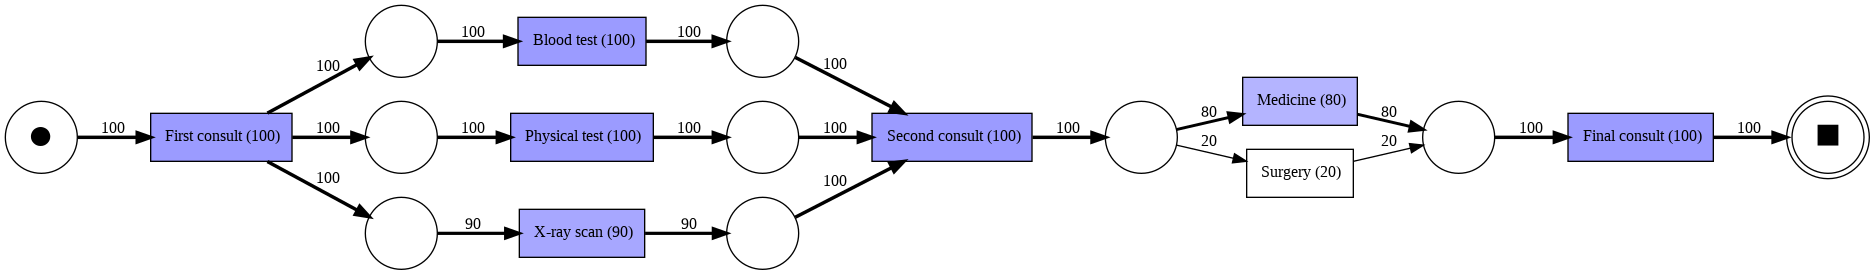

Куда зашли все 100 пациент(кейсы) - то и общее для всех, те: First consult, Physical test, Blood test, Second consult, Final consult, те 5 штук


In [40]:
from pm4py.algo.filtering.pandas import attributes

from pm4py.algo.filtering.pandas.attributes import attributes_filter
print("Список общих процедур для всех кейсов", [k for k in attributes_filter.get_attribute_values(log_csv, "concept:name") if  attributes_filter.get_attribute_values(log_csv, "concept:name")[k] == len(event_log)])


pn_visualizer.view(gviz)
print("Куда зашли все 100 пациент(кейсы) - то и общее для всех, те: First consult, Physical test, Blood test, Second consult, Final consult, те 5 штук")

3. Найдите наибоее часто встречающуюся последовательность событий.

In [41]:
from pm4py.statistics.traces.generic.log import case_statistics
variants_count = case_statistics.get_variant_statistics(log_csv)
print(variants_count[0])

{'variant': (' First consult', ' Blood test', ' X-ray scan', ' Physical test', ' Second consult', ' Medicine', ' Final consult'), 'count': 18}


4. Какой пациент на лечение тратил меньше всего времени, а какой больше?

5. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)

In [45]:
import numpy as np
import seaborn as sns
print(traces.keys())

seconds_to_days = 60*60*24
seconds_to_hours = 60*60

NumActions = NumActions.reset_index()
NumActions.columns = ['case:concept:name','NumActions']
log_csv=log_csv.merge(NumActions, on='case:concept:name')
case_starts_ends=log_csv.pivot_table(index='case:concept:name', aggfunc={'time:timestamp':['min','max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['case:concept:name','start','finish']
log_csv=log_csv.merge(case_starts_ends, on='case:concept:name')
log_csv['CaseLenght'] = log_csv['start']-log_csv['finish']
log_csv['CaseLenght']

dict_keys(["( First consult, ' First consult')", "( X-ray scan, ' X-ray scan')", "( Blood test, ' Blood test')", "( Physical test, ' Physical test')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])


ValueError: ignored

In [46]:
print(f"Максимальное время операции: {np.max(log_csv['CaseLenght'])}")
print(f"Минимальное время операции: {np.min(log_csv['CaseLenght'])}")
print("Самый долгий пациент", [k for k in attributes_filter.get_attribute_values(log_csv, ['CaseLenght',"case:concept:name"]) if k[0]==np.max(log_csv['CaseLenght'])]) #похоже на ужас, но зато в одну строчку
print("Самый быстрый пациент", [k for k in attributes_filter.get_attribute_values(log_csv, ['CaseLenght',"case:concept:name"]) if k[0]==np.min(log_csv['CaseLenght'])]) #похоже на ужас, но зато в одну строчку


Максимальное время операции: 17 days 02:43:04
Минимальное время операции: 1 days 01:34:04
Самый долгий пациент [(Timedelta('17 days 02:43:04'), 'patient 47')]
Самый быстрый пациент [(Timedelta('1 days 01:34:04'), 'patient 76')]


6. Pation 13 с каким врачом/врачами он/она консультировался?

In [47]:
from re import search
print(log_csv[log_csv['case:concept:name']=='patient 13'], '\n')

   case:concept:name     concept:name  org:resource      time:timestamp  \
89        patient 13    First consult       Dr. Bob 2017-01-23 15:09:10   
90        patient 13       X-ray scan        Team 2 2017-01-25 12:29:05   
91        patient 13    Physical test   Nurse Jesse 2017-01-25 13:34:31   
92        patient 13       Blood test           Lab 2017-01-25 14:25:04   
93        patient 13   Second consult      Dr. Anna 2017-01-27 12:37:29   
94        patient 13         Medicine      Pharmacy 2017-01-27 14:47:02   
95        patient 13    Final consult       Dr. Ben 2017-01-31 15:49:44   

               caseend           casestart    relativetime  relativetime_s  \
89 2017-01-31 15:49:44 2017-01-23 15:09:10 0 days 00:00:00               0   
90 2017-01-31 15:49:44 2017-01-23 15:09:10 1 days 21:19:55          163195   
91 2017-01-31 15:49:44 2017-01-23 15:09:10 1 days 22:25:21          167121   
92 2017-01-31 15:49:44 2017-01-23 15:09:10 1 days 23:15:54          170154   
93 2017-0

7. Какое событие является наиболее ресурсоёмким в данном журнале событий?

In [49]:
import time
log_csv
log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby(['case:concept:name'])['diff'].shift(-1)/3600

print(log_csv.groupby('concept:name')['time'].sum().sort_values(0, ascending=False))
#Blood test       0 days 01:20:33.284166625 - самое ресурсоемкое

concept:name
 Blood test       0 days 01:20:33.284166625
 Medicine         0 days 01:08:27.125277737
 Physical test    0 days 01:07:52.932222182
 First consult    0 days 01:01:52.173333290
 X-ray scan       0 days 00:44:46.849999961
 Second consult   0 days 00:43:31.852222178
 Surgery          0 days 00:16:00.683888880
 Final consult              0 days 00:00:00
Name: time, dtype: timedelta64[ns]


<ipython-input-49-378d50fd8a2f>:6: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  print(log_csv.groupby('concept:name')['time'].sum().sort_values(0, ascending=False))


8. Есть ли врачи или медсестры, которые перегружены работой? +

In [51]:
print(log_csv.groupby('org:resource')['time'].sum().sort_values(0, ascending=False))


org:resource
 Lab           0 days 01:20:33.284166625
 Pharmacy      0 days 01:08:27.125277737
 Dr. Bob       0 days 00:54:34.397222181
 Dr. Anna      0 days 00:50:49.628333287
 Nurse Jesse   0 days 00:37:15.065277754
 Nurse Corey   0 days 00:30:37.866944428
 Team 2        0 days 00:23:44.288055534
 Team 1        0 days 00:21:02.561944427
 Dr. Rudy      0 days 00:05:37.135833330
 Dr. Alex      0 days 00:05:22.890277776
 Dr. Charlie   0 days 00:03:52.926666664
 Dr. Quinn     0 days 00:01:07.731111110
 Dr. Ben                 0 days 00:00:00
Name: time, dtype: timedelta64[ns]


<ipython-input-51-ba45ace465fa>:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  print(log_csv.groupby('org:resource')['time'].sum().sort_values(0, ascending=False))


9. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер?
10.Каково распределение событий среди врачей и медсестер?
Какие события связаны с узкими местами и какие ресурсы задействованы?

In [52]:
pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               values=["time"],
               aggfunc=np.sum)

time
concept:name    org:resource                          
 Blood test      Lab         0 days 01:20:33.284166625
 Final consult   Dr. Anna              0 days 00:00:00
                 Dr. Ben               0 days 00:00:00
 First consult   Dr. Anna    0 days 00:27:43.779166643
                 Dr. Bob     0 days 00:34:08.394166647
 Medicine        Pharmacy    0 days 01:08:27.125277737
 Physical test   Nurse Corey 0 days 00:30:37.866944428
                 Nurse Jesse 0 days 00:37:15.065277754
 Second consult  Dr. Anna    0 days 00:23:05.849166644
                 Dr. Bob     0 days 00:20:26.003055534
 Surgery         Dr. Alex    0 days 00:05:22.890277776
                 Dr. Charlie 0 days 00:03:52.926666664
                 Dr. Quinn   0 days 00:01:07.731111110
                 Dr. Rudy    0 days 00:05:37.135833330
 X-ray scan      Team 1      0 days 00:21:02.561944427
                 Team 2      0 days 00:23:44.288055534

In [55]:
pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               values=["time"],
               aggfunc=np.mean)
#Самые узкие места связаны с Medicine, Syrgery, X-ray scan (по сети Петри понят, так как с этими элементами не все заимодействуют)

time
concept:name    org:resource                          
 Blood test      Lab         0 days 00:00:48.332841666
 First consult   Dr. Anna    0 days 00:00:31.392059747
                 Dr. Bob     0 days 00:00:43.582854609
 Medicine        Pharmacy    0 days 00:00:51.339065971
 Physical test   Nurse Corey 0 days 00:00:42.741091730
                 Nurse Jesse 0 days 00:00:39.211671539
 Second consult  Dr. Anna    0 days 00:00:25.197257575
                 Dr. Bob     0 days 00:00:27.244512345
 Surgery         Dr. Alex    0 days 00:01:04.578055555
                 Dr. Charlie 0 days 00:00:46.585333332
                 Dr. Quinn   0 days 00:00:22.577037036
                 Dr. Rudy    0 days 00:00:48.162261904
 X-ray scan      Team 1      0 days 00:00:31.564048610
                 Team 2      0 days 00:00:28.485761110

11. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

In [54]:
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])
import seaborn as sns
# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

KeyError: ignored

13. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.
Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

In [53]:
!pip install pyvis
from pyvis.network import Network
hw_values = pm4py.discover_handover_of_work_network(event_log)
sub_values = pm4py.discover_subcontracting_network(event_log)
wt_values = pm4py.discover_working_together_network(event_log)
ja_values = pm4py.discover_activity_based_resource_similarity(event_log)
roles = pm4py.discover_organizational_roles(event_log)
pm4py.view_sna(hw_values)
pm4py.view_sna(sub_values)
pm4py.view_sna(wt_values)
pm4py.view_sna(ja_values)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00


NameError: ignored

## Задание. Обнаружение модели процессов

1. По имеющемуся набору данных постройте модель процессов используя различные алгоритмы обнаружения процесса: inductive miner, heuristics miner, Alpha Miner, DFG граф.
Для каждой модели постройте сети Петри, сравните и сделайте вывод о том, какая модель больше всего подходит в данной задаче (привести значения различных метрик).


/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

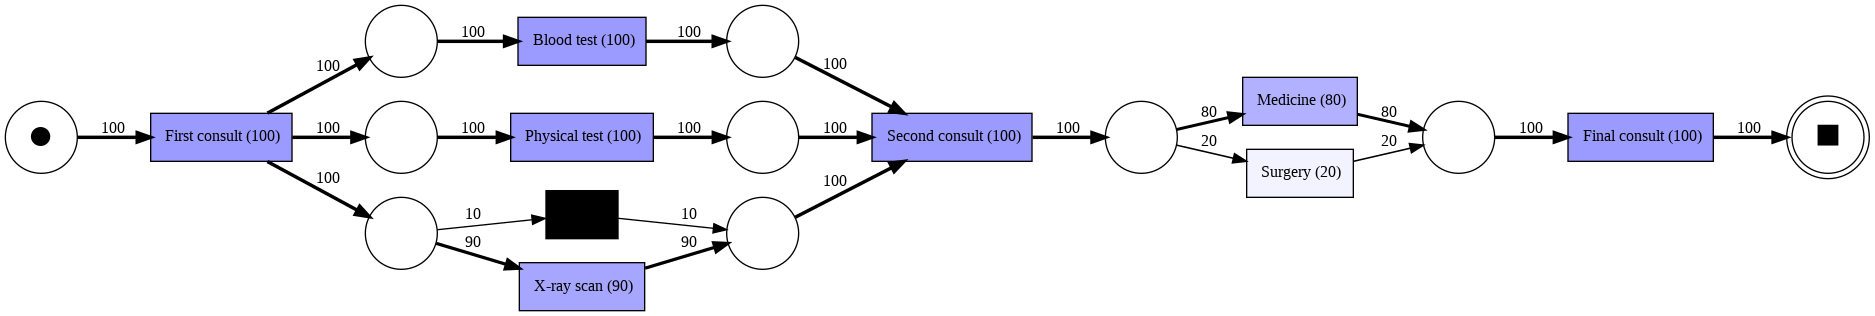

Простота равна  0.7599999999999999


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999992248122107}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.9840848806366048



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.9840848806366048



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

\Обобщенность равна 0.9840848806366048



In [56]:
#inductive miner
import pm4py
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator


from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
net, im, fm = pm4py.discover_petri_net_inductive(event_log)

parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)



simp = simplicity_evaluator.apply(net)
print("Простота равняется ", simp)

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\Обобщенность равна {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

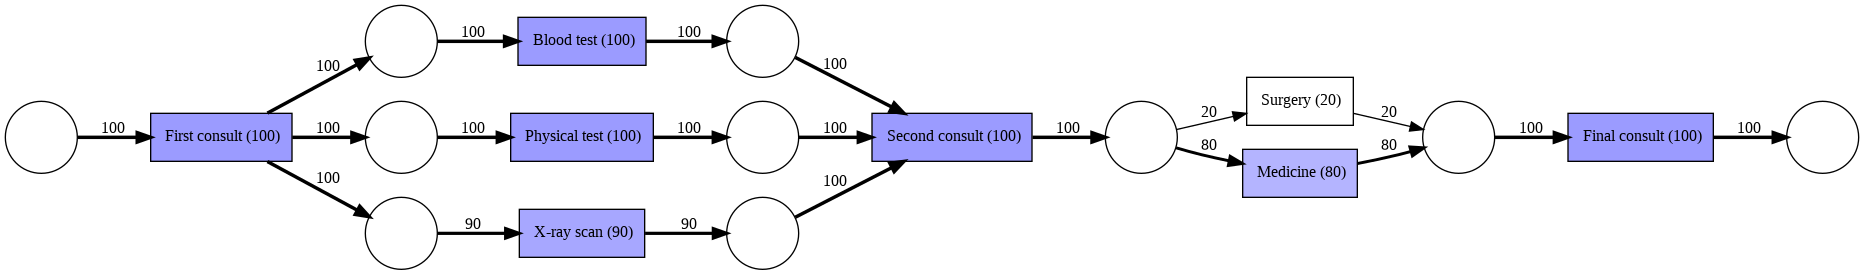

Простота равна  0.8181818181818181


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.9830188679245283



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

\Обобщенность равна 0.9830188679245283



In [57]:
#Alpha Miner
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
net, im, fm = alpha_miner.apply(event_log)
gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\Обобщенность равна {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

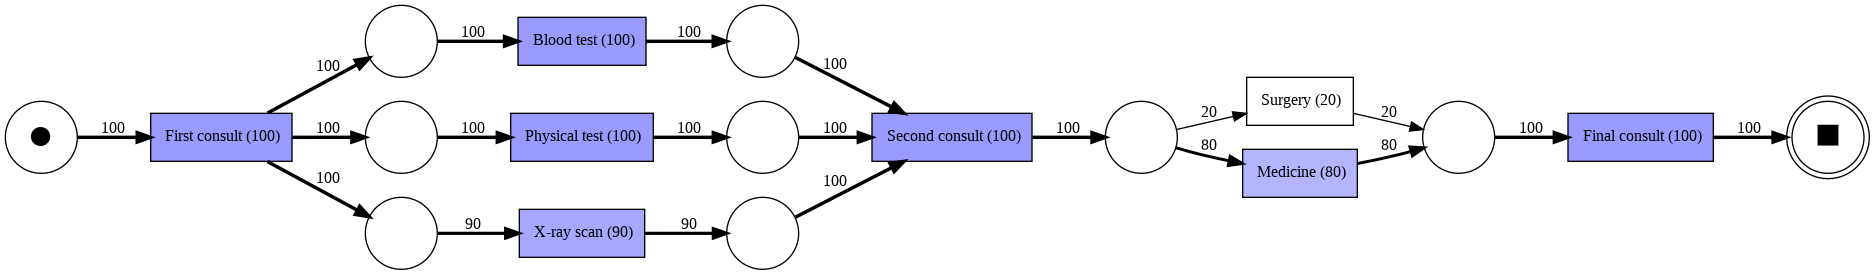

Простота равна  0.8181818181818181


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.9830188679245283



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

\Обобщенность равна 0.9830188679245283



In [58]:
#heuristics miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
net, im, fm = heuristics_miner.apply(event_log)
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\Обобщенность равна {prec}\n")

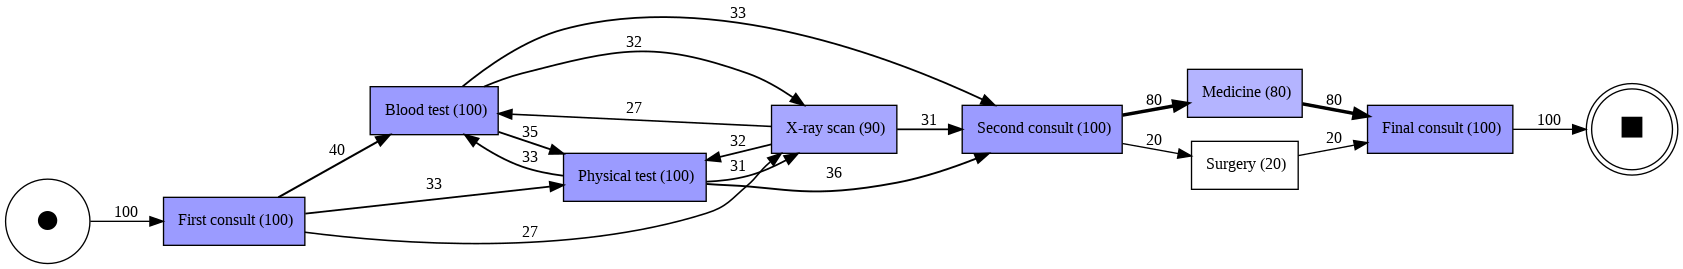

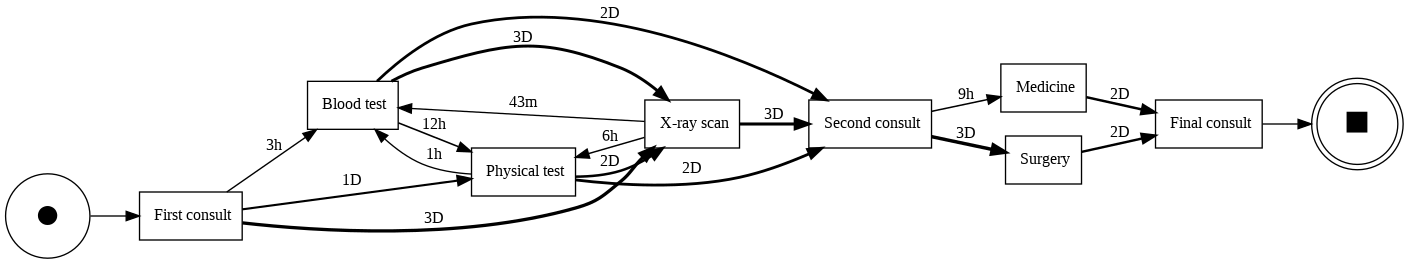

Простота равна  0.6363636363636362


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999915967092714}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.7089171974522293



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.7089171974522293



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

\Обобщенность равна 0.7089171974522293



In [59]:
#Directly-Follows Graph
#heuristics miner

dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(event_log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)
net, im, fm = pm4py.convert_to_petri_net(dfg, start_activities, end_activities)
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\Обобщенность равна {prec}\n")

По результатам анализа данных явного побидетеля нет, но по  обобщенности и другим качественным метрикам предпочтительнее Alpha Miner.